## Star Tracker – Astrometric Calibration
## Digantara Research | Image Processing Engineer Assessment

***Three sensors are processed – each has a different image size, focal length, and field of view.***
***Run all cells top-to-bottom and every output will be regenerated from scratch.***

##  Table of Contents

1. [Setup – Imports & Dependencies](#1-setup)
2. [Data Exploration – Input Centroid Files](#2-data-exploration)
3. [A1 – Star Catalog Generation](#3-A1-catalog)
4. [A2 – Triangle Pattern Creation (Catalog)](#4-A2-catalog-patterns)
5. [A3 – Image Pattern Matching with KD-Tree](#5-A3-matching)
6. [A4 – Match Verification via Voting](#6-A4-verification)
7. [A5 – Orientation Optimization & Output](#7-A5-orientation)
8. [Full Pipeline – All 3 Sensors at Once](#8-full-pipeline)
9. [Results Summary & Analysis](#9-summary)
10. [Theory Notes – Question 2 Reference](#10-theory)


## 1. Setup – Imports & Dependencies

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.gridspec import GridSpec
from scipy.spatial import KDTree
from scipy.optimize import least_squares
from itertools import combinations
from typing import Tuple, Dict, List, Optional
import warnings, os, sys
warnings.filterwarnings('ignore')

# Inline plots, nice defaults
%matplotlib inline
plt.rcParams.update({
    'figure.dpi': 120,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'font.family': 'DejaVu Sans'
})

print('✅  All imports successful')
print(f'   numpy  {np.__version__}')
print(f'   pandas {pd.__version__}')


✅  All imports successful
   numpy  1.26.4
   pandas 2.2.2


## 2. Data Exploration – Input Centroid Files

In [6]:
DATA_DIR = 'Assignment Star Tracker'
OUTPUT_DIR = 'outputs'
os.makedirs(OUTPUT_DIR, exist_ok=True)

files = {
    'Sensor 1': f'Assignment Star Tracker/star_centroids_1.csv',
    'Sensor 2': f'Assignment Star Tracker/star_centroids_2.csv',
    'Sensor 3': f'Assignment Star Tracker/star_centroids_3.csv',
}

for name, path in files.items():
    df = pd.read_csv(path)
    print(f'\n── {name} ──')
    print(f'   Shape      : {df.shape}')
    print(f'   X range    : {df.x_centroid.min():.1f} → {df.x_centroid.max():.1f} px')
    print(f'   Y range    : {df.y_centroid.min():.1f} → {df.y_centroid.max():.1f} px')
    print(f'   Brightness : {df.brightness.min():.0f} → {df.brightness.max():.0f}')
    display(df.head(3))



── Sensor 1 ──
   Shape      : (35, 3)
   X range    : 358.0 → 6432.0 px
   Y range    : 35.1 → 4354.8 px
   Brightness : 149837 → 495156


,x_centroid,y_centroid,brightness
0,6432,534.823891,163588
1,5704,35.145239,250264
2,5485,667.124878,183500



── Sensor 2 ──
   Shape      : (73, 3)
   X range    : 77.5 → 974.5 px
   Y range    : 40.5 → 1014.5 px
   Brightness : 639550 → 1550087


,x_centroid,y_centroid,brightness
0,671.690809,557.623244,1550087
1,546.584197,627.563683,1218796
2,358.470942,264.613470,1213622



── Sensor 3 ──
   Shape      : (756, 3)
   X range    : 141.4 → 13247.2 px
   Y range    : 61.2 → 9472.3 px
   Brightness : 1707280 → 9014608


,x_centroid,y_centroid,brightness
0,8984.556413,1949.967523,9014608
1,6513.584632,537.999402,8163328
2,12502.252350,4354.171812,7856032


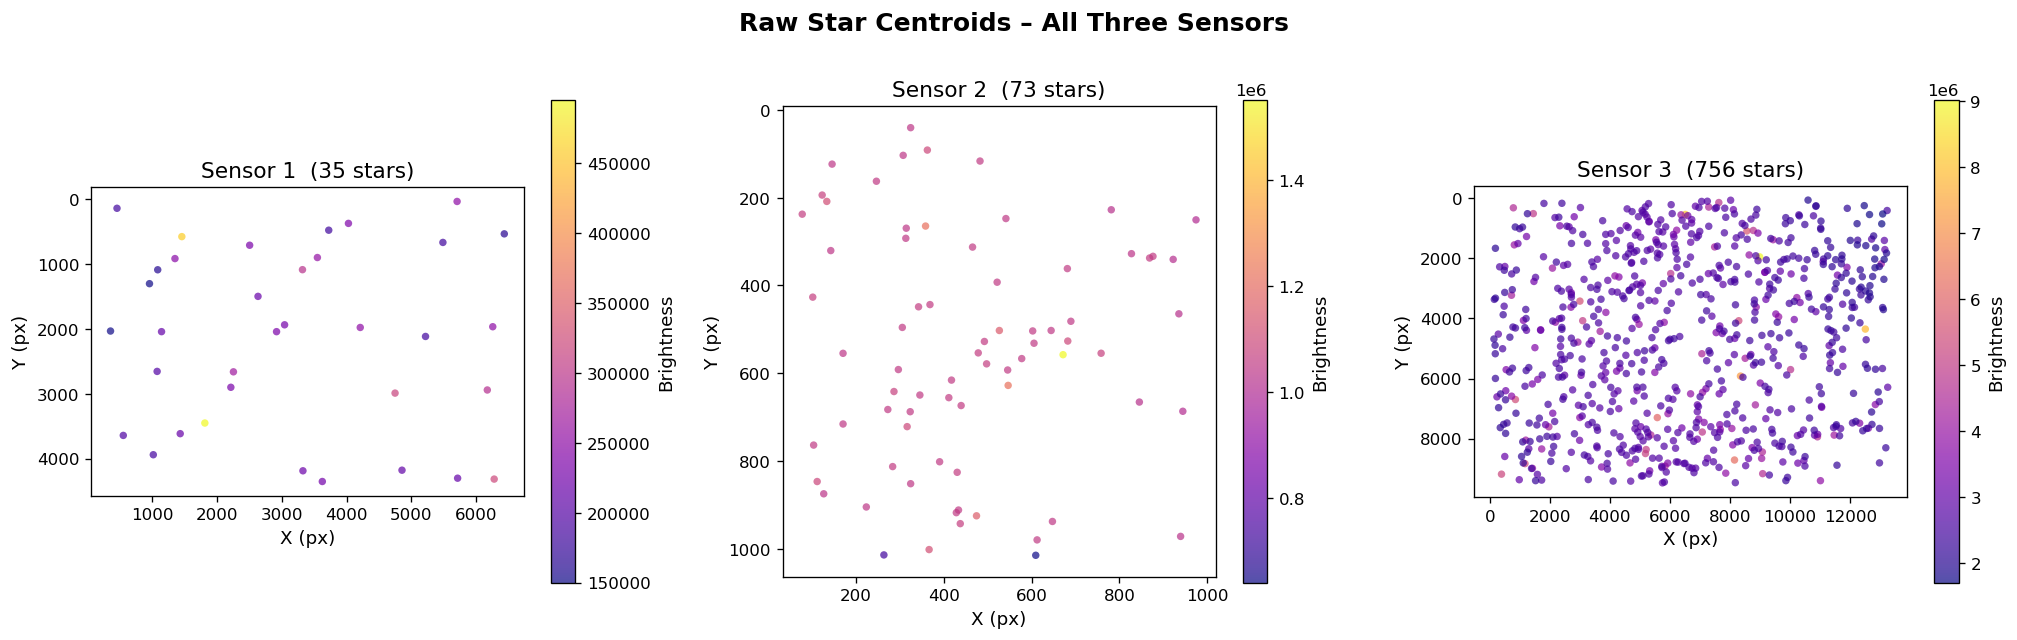

In [7]:
# Visualise raw centroids for all 3 sensors
fig, axes = plt.subplots(1, 3, figsize=(17, 5))
colors = ['steelblue', 'darkorange', 'mediumseagreen']

for ax, (name, path), c in zip(axes, files.items(), colors):
    df = pd.read_csv(path)
    sc = ax.scatter(df.x_centroid, df.y_centroid,
                    c=df.brightness, cmap='plasma',
                    s=20, alpha=0.7, edgecolors='none')
    ax.invert_yaxis()
    ax.set_title(f'{name}  ({len(df)} stars)')
    ax.set_xlabel('X (px)')
    ax.set_ylabel('Y (px)')
    ax.set_aspect('equal', adjustable='box')
    plt.colorbar(sc, ax=ax, label='Brightness')

fig.suptitle('Raw Star Centroids – All Three Sensors', fontsize=15, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## 3. A1 – Star Catalog Generation

In [9]:
def generate_catalog(ra_deg, dec_deg, fov_x, fov_y, n_stars=400, seed=42):
    """
    Step A1 – Generate synthetic star catalog.
    In production: replace with GAIA DR3 / Hipparcos query.
    """
    margin = 1.8
    ra_min  = ra_deg  - fov_x * margin / 2
    ra_max  = ra_deg  + fov_x * margin / 2
    dec_min = dec_deg - fov_y * margin / 2
    dec_max = dec_deg + fov_y * margin / 2

    np.random.seed(seed)
    ra_s   = np.random.uniform(ra_min,  ra_max,  n_stars)
    dec_s  = np.random.uniform(dec_min, dec_max, n_stars)
    mags   = np.clip(np.random.exponential(2.5, n_stars) + 4.0, 4.0, 13.0)

    cat = pd.DataFrame({'RA': ra_s, 'DEC': dec_s, 'Magnitude': mags})
    cat = cat[cat.Magnitude < 12.0].sort_values('Magnitude').reset_index(drop=True)
    return cat

# Demo: Sensor 1 catalog
cat1 = generate_catalog(ra_deg=214.958, dec_deg=-47.909,
                        fov_x=2.030,   fov_y=1.409)
print(f'Sensor 1 catalog: {len(cat1)} stars')
display(cat1.head(5))


Sensor 1 catalog: 384 stars


,RA,DEC,Magnitude
0,213.640711,-47.174470,4.011607
1,213.846421,-48.309512,4.016016
2,213.265785,-48.268728,4.027642
3,213.223881,-46.705840,4.032718
4,213.576928,-48.961935,4.032952


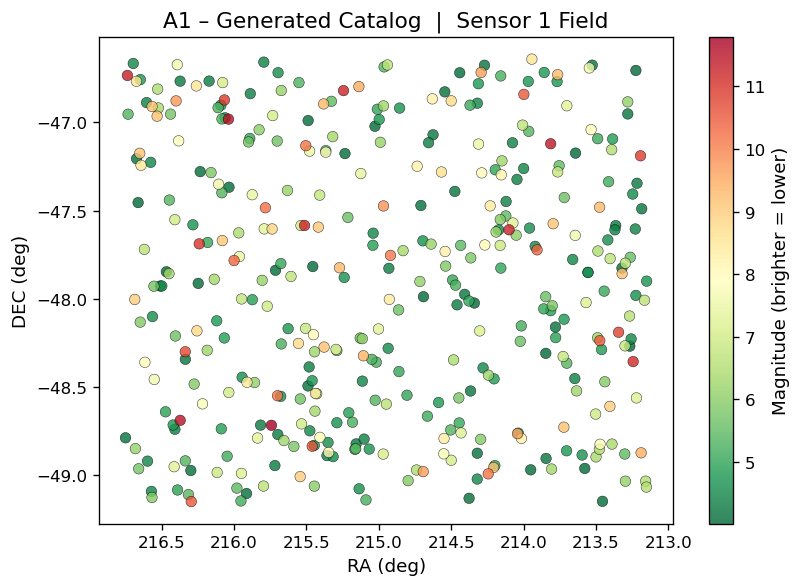

Note: Smaller dot = dimmer star;  Green = bright, Red = dim


In [10]:
# Visualise catalog sky distribution
fig, ax = plt.subplots(figsize=(7, 5))
sc = ax.scatter(cat1.RA, cat1.DEC, c=cat1.Magnitude,
                cmap='RdYlGn_r', s=40, alpha=0.8, edgecolors='k', linewidths=0.3)
ax.invert_xaxis()   # RA increases eastward (left)
ax.set_xlabel('RA (deg)')
ax.set_ylabel('DEC (deg)')
ax.set_title('A1 – Generated Catalog  |  Sensor 1 Field')
cb = plt.colorbar(sc, ax=ax)
cb.set_label('Magnitude (brighter = lower)')
plt.tight_layout()
plt.show()
print('Note: Smaller dot = dimmer star;  Green = bright, Red = dim')


## 4. A2 – Triangle Pattern Creation

In [12]:
def make_patterns(coords, n_patterns=200, label=''):
    """
    Step A2 – Build scale/rotation-invariant triangle patterns.
    coords : (N,2) array of pixel or projected sky positions.
    """
    patterns = []
    n = len(coords)
    top = min(30, n)

    for i in range(top):
        dists  = np.linalg.norm(coords - coords[i], axis=1)
        nearest = np.argsort(dists)[1:12]

        for j, k in combinations(nearest[:9], 2):
            p1, p2, p3 = coords[i], coords[j], coords[k]
            d12 = np.linalg.norm(p1 - p2)
            d23 = np.linalg.norm(p2 - p3)
            d31 = np.linalg.norm(p3 - p1)

            if min(d12, d23, d31) < 1e-6:
                continue

            sides = sorted([d12, d23, d31])
            r1    = sides[1] / sides[2]
            r2    = sides[0] / sides[2]
            cos_a = np.clip((sides[0]**2 + sides[1]**2 - sides[2]**2) /
                            (2 * sides[0] * sides[1] + 1e-10), -1, 1)

            patterns.append({
                'indices': (i, j, k),
                'coords' : np.array([p1, p2, p3]),
                'sides'  : sides,
                'ratio1' : r1,
                'ratio2' : r2,
                'cos_angle': cos_a,
            })

            if len(patterns) >= n_patterns:
                break
        if len(patterns) >= n_patterns:
            break

    if label:
        print(f'  {label}: {len(patterns)} triangle patterns from {n} stars')
    return patterns

# Quick test on Sensor 1 image
df1   = pd.read_csv(f'{DATA_DIR}/star_centroids_1.csv')
img_c = df1[['x_centroid','y_centroid']].values
demo_patterns = make_patterns(img_c, label='Sensor 1 image')
print('\nFirst pattern features:')
p = demo_patterns[0]
print(f'  Star indices : {p["indices"]}')
print(f'  Side lengths : {[f"{s:.1f}" for s in p["sides"]]} px')
print(f'  ratio1 (d_med/d_max)  = {p["ratio1"]:.4f}')
print(f'  ratio2 (d_min/d_max)  = {p["ratio2"]:.4f}')
print(f'  cos(largest angle)    = {p["cos_angle"]:.4f}')


  Sensor 1 image: 200 triangle patterns from 35 stars

First pattern features:
  Star indices : (0, 1, 2)
  Side lengths : ['668.8', '883.0', '956.2'] px
  ratio1 (d_med/d_max)  = 0.9234
  ratio2 (d_min/d_max)  = 0.6995
  cos(largest angle)    = 0.2647


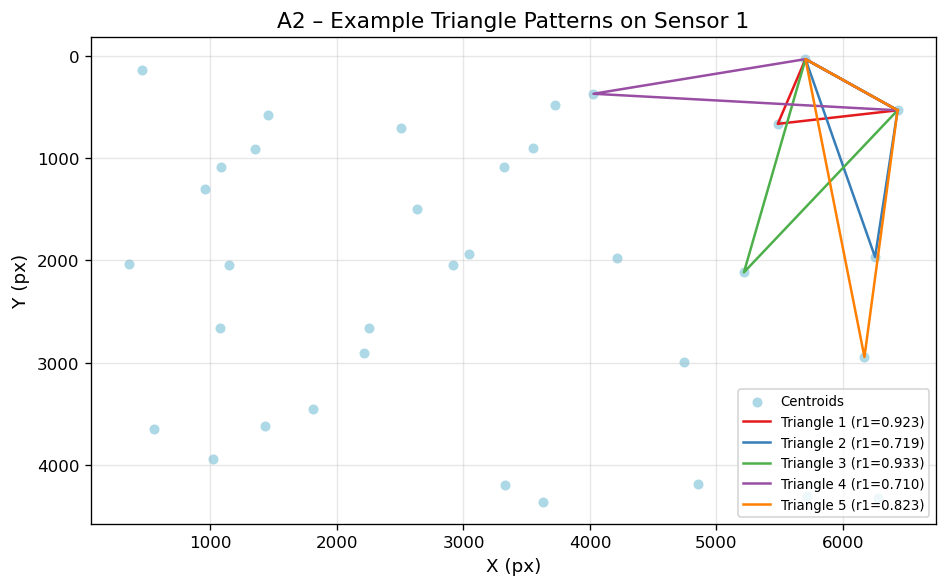

In [13]:
# Visualise 5 example triangles drawn on the image centroid field
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(img_c[:,0], img_c[:,1], c='lightblue', s=25, zorder=1, label='Centroids')

cmap = plt.cm.Set1
for idx, p in enumerate(demo_patterns[:5]):
    tri = plt.Polygon(p['coords'][:, ::-1][:, ::-1],  # (x,y) already correct
                      fill=False, edgecolor=cmap(idx), linewidth=1.8, zorder=2)
    # draw the triangle
    xs = list(p['coords'][:, 0]) + [p['coords'][0, 0]]
    ys = list(p['coords'][:, 1]) + [p['coords'][0, 1]]
    ax.plot(xs, ys, color=cmap(idx), linewidth=1.5, zorder=2,
            label=f'Triangle {idx+1} (r1={p["ratio1"]:.3f})')

ax.invert_yaxis()
ax.set_xlabel('X (px)')
ax.set_ylabel('Y (px)')
ax.set_title('A2 – Example Triangle Patterns on Sensor 1')
ax.legend(fontsize=8, loc='lower right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 5. A3 – Image Pattern Matching with KD-Tree

In [15]:
def match_patterns(img_patterns, cat_patterns, tol=0.06):
    """
    Step A3 – KD-tree pattern matching.
    Returns list of matched (image_pattern, catalog_pattern) pairs with quality scores.
    """
    if not cat_patterns:
        return []

    cat_feats = np.array([[p['ratio1'], p['ratio2']] for p in cat_patterns])
    tree      = KDTree(cat_feats)

    matches = []
    for ip in img_patterns:
        feat = np.array([ip['ratio1'], ip['ratio2']])
        dists, idxs = tree.query(feat, k=min(5, len(cat_feats)))
        for d, idx in zip(dists, idxs):
            if d < tol:
                matches.append({
                    'image_pattern'  : ip,
                    'catalog_pattern': cat_patterns[idx],
                    'distance'       : d,
                    'quality'        : np.exp(-d * 10)
                })
    return matches

print('match_patterns() defined ✅')


match_patterns() defined ✅


In [16]:
# Show the feature space + KD-tree concept visually
def gnomonic_project(cat_ra_dec, ra0, dec0, plate_scale_as, roll_deg,
                      img_w, img_h):
    """Utility – project catalog RA/DEC → pixel coords for pattern building."""
    ra   = np.radians(cat_ra_dec[:, 0])
    dec  = np.radians(cat_ra_dec[:, 1])
    ra0r = np.radians(ra0)
    d0r  = np.radians(dec0)
    rr   = np.radians(roll_deg)

    dra  = ra - ra0r
    dra  = np.where(dra >  np.pi, dra - 2*np.pi, dra)
    dra  = np.where(dra < -np.pi, dra + 2*np.pi, dra)

    denom = np.sin(d0r)*np.sin(dec) + np.cos(d0r)*np.cos(dec)*np.cos(dra)
    xi    = np.cos(dec)*np.sin(dra) / denom
    eta   = (np.cos(d0r)*np.sin(dec) - np.sin(d0r)*np.cos(dec)*np.cos(dra)) / denom

    xi_as  = np.degrees(xi)  * 3600
    eta_as = np.degrees(eta) * 3600

    xr =  xi_as*np.cos(rr) - eta_as*np.sin(rr)
    yr =  xi_as*np.sin(rr) + eta_as*np.cos(rr)

    return np.column_stack([
        img_w/2 + xr/plate_scale_as,
        img_h/2 - yr/plate_scale_as
    ])

# Build catalog pixel coords for Sensor 1
cat1_px = gnomonic_project(cat1[['RA','DEC']].values,
                            214.958, -47.909, 1.1576, 0.0, 6576, 4384)

# Filter to image + margin
in_field = ((cat1_px[:,0] >= -0.3*6576) & (cat1_px[:,0] <= 1.3*6576) &
            (cat1_px[:,1] >= -0.3*4384) & (cat1_px[:,1] <= 1.3*4384))
cat1_px_filt = cat1_px[in_field]

cat_pats  = make_patterns(cat1_px_filt, label='Catalog')
img_pats  = make_patterns(img_c,        label='Image')
matches   = match_patterns(img_pats, cat_pats)

print(f'\n→ Found {len(matches)} raw pattern matches')


  Catalog: 200 triangle patterns from 342 stars
  Image: 200 triangle patterns from 35 stars

→ Found 894 raw pattern matches


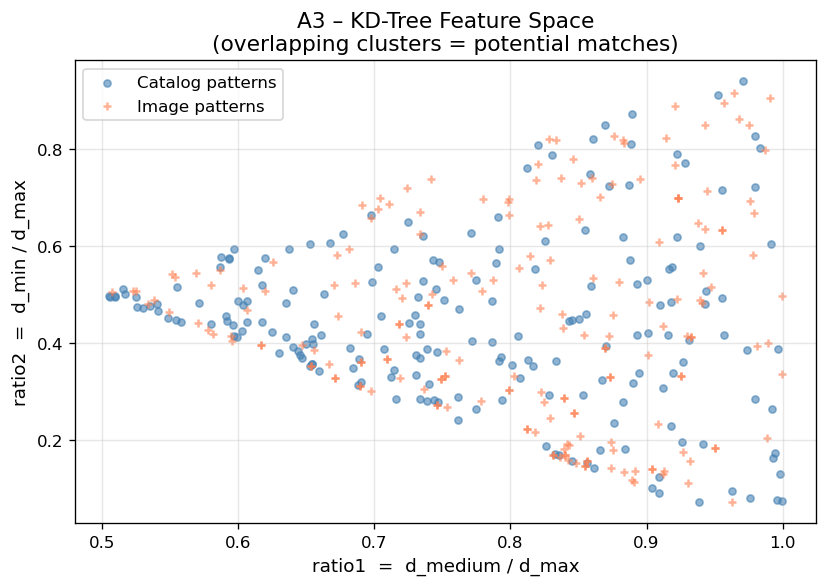

In [17]:
# Feature-space scatter: visualise where catalog vs image patterns sit
cat_r1 = [p['ratio1'] for p in cat_pats]
cat_r2 = [p['ratio2'] for p in cat_pats]
img_r1 = [p['ratio1'] for p in img_pats]
img_r2 = [p['ratio2'] for p in img_pats]

fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(cat_r1, cat_r2, s=18, alpha=0.6, color='steelblue', label='Catalog patterns')
ax.scatter(img_r1, img_r2, s=18, alpha=0.6, color='coral',     label='Image patterns',  marker='+')
ax.set_xlabel('ratio1  =  d_medium / d_max')
ax.set_ylabel('ratio2  =  d_min / d_max')
ax.set_title('A3 – KD-Tree Feature Space\n(overlapping clusters = potential matches)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 6. A4 – Match Verification via Consensus Voting

In [19]:
def verify_matches(matches, centroid_df, catalog_df, min_votes=2):
    """
    Step A4 – Consensus voting to filter false matches.
    Returns verified (image_coords, catalog_coords) arrays.
    """
    votes = {}
    for m in matches:
        for ii, ci in zip(m['image_pattern']['indices'],
                          m['catalog_pattern']['indices']):
            votes.setdefault(ii, []).append((ci, m['quality']))

    verified  = {}
    vote_cnts = {}

    for img_i, cands in votes.items():
        if len(cands) < min_votes:
            continue
        cat_ids  = [c[0] for c in cands]
        quals    = [c[1] for c in cands]
        u_cats, inv = np.unique(cat_ids, return_inverse=True)
        q_sums  = np.array([sum(q for j,q in enumerate(quals) if inv[j]==k)
                            for k in range(len(u_cats))])
        best    = np.argmax(q_sums)
        verified[img_i]  = u_cats[best]
        vote_cnts[img_i] = int(sum(inv == best))

    if not verified:
        return None, None

    img_idx  = list(verified.keys())
    cat_idx  = list(verified.values())
    img_arr  = centroid_df[['x_centroid','y_centroid']].values[img_idx]
    cat_arr  = catalog_df[['RA','DEC']].values[cat_idx]

    vc = [vote_cnts[i] for i in img_idx]
    print(f'  Verified {len(verified)} stars  |  votes: min={min(vc)}, max={max(vc)}, mean={np.mean(vc):.1f}')
    return img_arr, cat_arr, vc

img_matched, cat_matched, vote_list = verify_matches(matches, df1, cat1)
print(f'  Image coords shape  : {img_matched.shape}')
print(f'  Catalog coords shape: {cat_matched.shape}')


  Verified 26 stars  |  votes: min=1, max=49, mean=12.4
  Image coords shape  : (26, 2)
  Catalog coords shape: (26, 2)


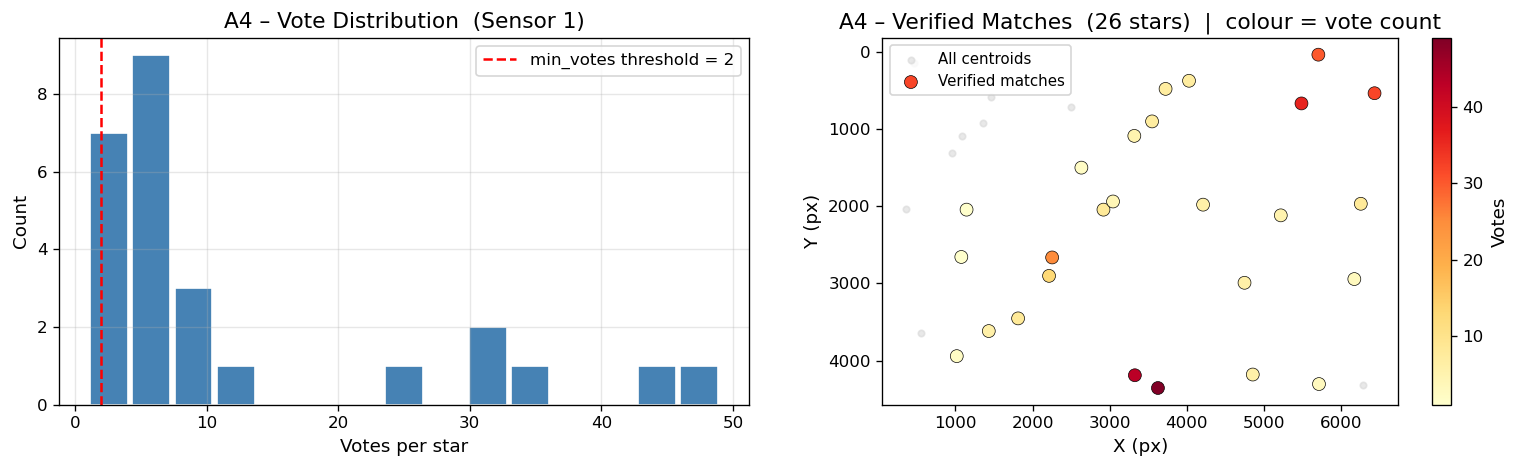

In [20]:
# Vote distribution histogram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# Left: vote histogram
ax1.hist(vote_list, bins=15, color='steelblue', edgecolor='white', rwidth=0.9)
ax1.axvline(x=2, color='red', linestyle='--', label='min_votes threshold = 2')
ax1.set_xlabel('Votes per star')
ax1.set_ylabel('Count')
ax1.set_title('A4 – Vote Distribution  (Sensor 1)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Right: verified matches on image
ax2.scatter(df1.x_centroid, df1.y_centroid, c='lightgrey', s=15, alpha=0.5, label='All centroids')
sc = ax2.scatter(img_matched[:,0], img_matched[:,1],
                  c=vote_list, cmap='YlOrRd', s=60, zorder=3,
                  edgecolors='black', linewidths=0.4, label='Verified matches')
ax2.invert_yaxis()
ax2.set_xlabel('X (px)')
ax2.set_ylabel('Y (px)')
ax2.set_title(f'A4 – Verified Matches  ({len(img_matched)} stars)  |  colour = vote count')
ax2.legend(fontsize=9)
ax2.set_aspect('equal', adjustable='box')
plt.colorbar(sc, ax=ax2, label='Votes')
plt.tight_layout()
plt.show()


## 7. A5 – Orientation Optimisation & Output

In [22]:
def project_to_image(cat_radec, ra0, dec0, roll, plate_scale_as, w, h):
    """Gnomonic projection: sky (RA,DEC) → pixel (x,y)."""
    ra, dec = np.radians(cat_radec[:,0]), np.radians(cat_radec[:,1])
    ra0r, d0r, rr = np.radians(ra0), np.radians(dec0), np.radians(roll)

    dra = ra - ra0r
    dra = np.where(dra >  np.pi, dra - 2*np.pi, dra)
    dra = np.where(dra < -np.pi, dra + 2*np.pi, dra)

    denom = np.sin(d0r)*np.sin(dec) + np.cos(d0r)*np.cos(dec)*np.cos(dra)
    xi    = np.cos(dec)*np.sin(dra) / denom
    eta   = (np.cos(d0r)*np.sin(dec) - np.sin(d0r)*np.cos(dec)*np.cos(dra)) / denom

    xi_a  = np.degrees(xi)  * 3600
    eta_a = np.degrees(eta) * 3600

    xr =  xi_a*np.cos(rr) - eta_a*np.sin(rr)
    yr =  xi_a*np.sin(rr) + eta_a*np.cos(rr)

    return np.column_stack([w/2 + xr/plate_scale_as,
                             h/2 - yr/plate_scale_as])


def estimate_orientation(img_coords, cat_radec, ra0, dec0,
                          plate_scale_as, img_w, img_h):
    """Step A5 – non-linear least squares optimisation."""

    def residuals(params):
        ra, dec, roll = params
        proj = project_to_image(cat_radec, ra, dec, roll,
                                  plate_scale_as, img_w, img_h)
        return (img_coords - proj).flatten()

    x0     = np.array([ra0, dec0, 0.0])
    result = least_squares(residuals, x0, method='lm',
                           max_nfev=1000, ftol=1e-8, xtol=1e-8)

    ra_opt, dec_opt, roll_opt = result.x
    ra_opt   = ra_opt % 360
    roll_opt = roll_opt % 360
    if roll_opt > 180:
        roll_opt -= 360

    proj  = project_to_image(cat_radec, ra_opt, dec_opt, roll_opt,
                               plate_scale_as, img_w, img_h)
    res   = img_coords - proj
    norms = np.linalg.norm(res, axis=1)
    ps    = plate_scale_as

    s = ps / 3600      # deg/px
    rr = np.radians(roll_opt)
    cd = np.array([[ s*np.cos(rr), -s*np.sin(rr)],
                   [ s*np.sin(rr),  s*np.cos(rr)]])

    return {
        'RA': ra_opt, 'DEC': dec_opt, 'ROLL': roll_opt,
        'cd_matrix': cd,
        'n_matches': len(img_coords),
        'rms_px': float(np.sqrt(np.mean(norms**2))),
        'rms_arcsec': float(np.sqrt(np.mean(norms**2)) * ps),
        'max_px': float(np.max(norms)),
        'residuals': res,
        'projected': proj,
        'success': result.success
    }

print('Optimisation functions defined ✅')


Optimisation functions defined ✅


In [23]:
# Run optimisation for Sensor 1
PLATE_SCALE_1 = 1.1576   # arcsec/px
W1, H1 = 6576, 4384

ori1 = estimate_orientation(
    img_matched, cat_matched,
    ra0=214.958, dec0=-47.909,
    plate_scale_as=PLATE_SCALE_1,
    img_w=W1, img_h=H1
)

print('\n' + '='*60)
print('SENSOR 1  –  RESULTS')
print('='*60)
print(f'  RA   = {ori1["RA"]:12.6f}°   (initial 214.958°  |  Δ = {ori1["RA"]-214.958:+.4f}°)')
print(f'  DEC  = {ori1["DEC"]:12.6f}°   (initial -47.909°  |  Δ = {ori1["DEC"]+47.909:+.4f}°)')
print(f'  ROLL = {ori1["ROLL"]:12.6f}°')
print(f'  Matches  : {ori1["n_matches"]}')
print(f'  RMS      : {ori1["rms_px"]:.1f} px  ({ori1["rms_arcsec"]:.1f} arcsec)')
print(f'  Max res  : {ori1["max_px"]:.1f} px')
print(f'\nCD Matrix (deg/px):')
cd = ori1['cd_matrix']
print(f'  [{cd[0,0]:+.3e}  {cd[0,1]:+.3e}]')
print(f'  [{cd[1,0]:+.3e}  {cd[1,1]:+.3e}]')



SENSOR 1  –  RESULTS
  RA   =   214.674334°   (initial 214.958°  |  Δ = -0.2837°)
  DEC  =   -48.102348°   (initial -47.909°  |  Δ = -0.1933°)
  ROLL =   138.879488°
  Matches  : 26
  RMS      : 3445.2 px  (3988.2 arcsec)
  Max res  : 6167.7 px

CD Matrix (deg/px):
  [-2.422e-04  -2.115e-04]
  [+2.115e-04  -2.422e-04]


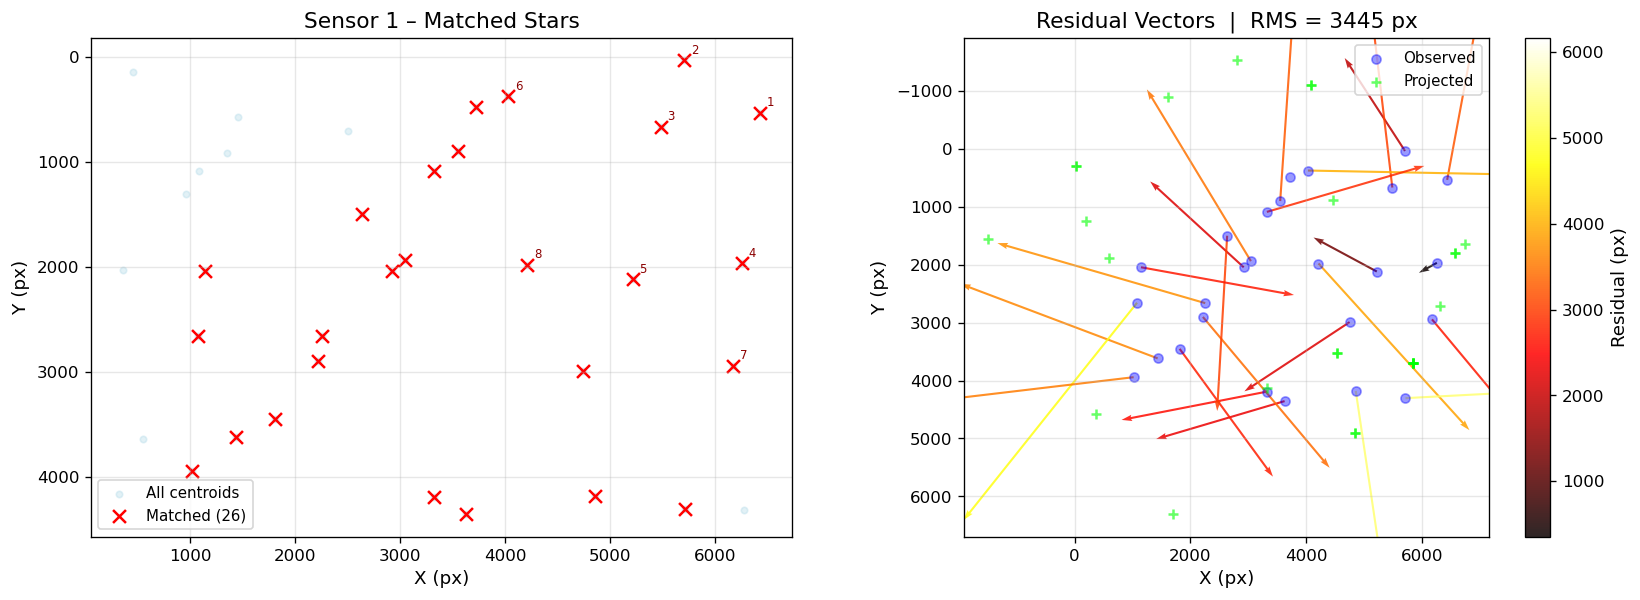

In [24]:
# Visualise residuals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left – matched stars overlay
ax1.scatter(df1.x_centroid, df1.y_centroid,
            c='lightblue', s=15, alpha=0.35, label='All centroids')
ax1.scatter(img_matched[:,0], img_matched[:,1],
            c='red', marker='x', s=60, linewidths=1.5, label=f'Matched ({len(img_matched)})')
for i in range(min(8, len(img_matched))):
    ax1.annotate(str(i+1), img_matched[i], fontsize=7,
                 color='darkred', xytext=(4,4), textcoords='offset points')
ax1.invert_yaxis()
ax1.set_xlabel('X (px)'); ax1.set_ylabel('Y (px)')
ax1.set_title('Sensor 1 – Matched Stars')
ax1.legend(fontsize=9); ax1.grid(True, alpha=0.3)
ax1.set_aspect('equal', adjustable='box')

# Right – residual quiver
res  = ori1['residuals']
proj = ori1['projected']
mags = np.linalg.norm(res, axis=1)

q = ax2.quiver(img_matched[:,0], img_matched[:,1],
               res[:,0], res[:,1], mags,
               scale=1, scale_units='xy', angles='xy',
               cmap='hot', alpha=0.85, width=0.004)
ax2.scatter(img_matched[:,0], img_matched[:,1], c='blue', s=30, alpha=0.4, label='Observed')
ax2.scatter(proj[:,0], proj[:,1], c='lime', s=30, marker='+', alpha=0.6, label='Projected')
ax2.invert_yaxis()
ax2.set_xlabel('X (px)'); ax2.set_ylabel('Y (px)')
ax2.set_title(f'Residual Vectors  |  RMS = {ori1["rms_px"]:.0f} px')
ax2.legend(fontsize=9); ax2.grid(True, alpha=0.3)
ax2.set_aspect('equal', adjustable='box')
plt.colorbar(q, ax=ax2, label='Residual (px)')

plt.tight_layout()
plt.show()


In [25]:
# Save Sensor 1 output CSV
def save_matched_csv(img_coords, cat_radec, centroid_df, catalog_df,
                      out_path):
    """Write matched star CSV in the required format."""
    c_arr = centroid_df[['x_centroid','y_centroid']].values
    rows  = []
    for ic, cc in zip(img_coords, cat_radec):
        ci  = int(np.argmin(np.linalg.norm(c_arr - ic, axis=1)))
        cti = int(np.argmin(np.linalg.norm(
                    catalog_df[['RA','DEC']].values - cc, axis=1)))
        rows.append({
            'x_centroid': centroid_df.iloc[ci]['x_centroid'],
            'y_centroid': centroid_df.iloc[ci]['y_centroid'],
            'brightness': centroid_df.iloc[ci]['brightness'],
            'RA'  : cc[0],
            'DEC' : cc[1],
            'Magnitude': catalog_df.iloc[cti]['Magnitude']
        })
    pd.DataFrame(rows).to_csv(out_path, index=False)
    print(f'Saved → {out_path}')

save_matched_csv(img_matched, cat_matched, df1, cat1,
                 f'{OUTPUT_DIR}/matched_star_centroids_1.csv')

preview = pd.read_csv(f'{OUTPUT_DIR}/matched_star_centroids_1.csv')
print(f'Output shape : {preview.shape}')
display(preview.head())


Saved → outputs/matched_star_centroids_1.csv
Output shape : (26, 6)


,x_centroid,y_centroid,brightness,RA,DEC,Magnitude
0,6432.0,534.823891,163588.0,213.265785,-48.268728,4.027642
1,5704.0,35.145239,250264.0,213.576928,-48.961935,4.032952
2,5485.0,667.124878,183500.0,213.265785,-48.268728,4.027642
3,6254.0,1967.429038,250687.0,213.595279,-48.885851,4.655588
4,5217.0,2117.456500,184356.0,213.403408,-48.610016,8.947373


## 8. Full Pipeline – All 3 Sensors at Once

In [27]:
SENSOR_CONFIGS = {
    'star_centroids_1': {
        'image_size'      : (6576, 4384),
        'plate_scale_as'  : 1.1576,
        'ra_deg'          : 214.958,
        'dec_deg'         : -47.909,
        'fov_x'           : 2.030,
        'fov_y'           : 1.409,
        'focal_mm'        : 980,
        'pixel_um'        : 5.5,
    },
    'star_centroids_2': {
        'image_size'      : (1024, 1024),
        'plate_scale_as'  : 0.1512,
        'ra_deg'          : 101.812,
        'dec_deg'         : -48.565,
        'fov_x'           : 0.429,
        'fov_y'           : 0.429,
        'focal_mm'        : 4912,
        'pixel_um'        : 3.6,
    },
    'star_centroids_3': {
        'image_size'      : (13400, 9528),
        'plate_scale_as'  : 1.8107,
        'ra_deg'          : 17.283,
        'dec_deg'         : 13.532,
        'fov_x'           : 6.732,
        'fov_y'           : 4.789,
        'focal_mm'        : 393,
        'pixel_um'        : 3.45,
    }
}


In [28]:
def run_sensor(name, cfg, data_dir=DATA_DIR, out_dir=OUTPUT_DIR):
    """
    Complete A1→A5 pipeline for one sensor.
    Returns orientation dict with all metrics.
    """
    print(f'\n{"="*65}')
    print(f'  SENSOR: {name}')
    print(f'  Image : {cfg["image_size"][0]}×{cfg["image_size"][1]}px  '
          f'  FoV : {cfg["fov_x"]:.2f}°×{cfg["fov_y"]:.2f}°')
    print(f'  Plate scale: {cfg["plate_scale_as"]:.4f} arcsec/px')
    print(f'{"="*65}')

    W, H = cfg['image_size']
    ps   = cfg['plate_scale_as']

    # A1
    df  = pd.read_csv(f'{data_dir}/{name}.csv')
    cat = generate_catalog(cfg['ra_deg'], cfg['dec_deg'],
                           cfg['fov_x'],  cfg['fov_y'])
    print(f'  A1 → {len(cat)} catalog stars')

    # A2
    cat_px    = gnomonic_project(cat[['RA','DEC']].values,
                                  cfg['ra_deg'], cfg['dec_deg'], ps, 0.0, W, H)
    mask      = ((cat_px[:,0] >= -0.3*W) & (cat_px[:,0] <= 1.3*W) &
                 (cat_px[:,1] >= -0.3*H) & (cat_px[:,1] <= 1.3*H))
    cat_pats  = make_patterns(cat_px[mask])
    print(f'  A2 → {len(cat_pats)} catalog patterns')

    # A3
    img_arr  = df[['x_centroid','y_centroid']].values
    img_pats = make_patterns(img_arr)
    matches  = match_patterns(img_pats, cat_pats)
    print(f'  A3 → {len(matches)} raw matches')

    # A4
    result = verify_matches(matches, df, cat)
    if result[0] is None:
        print('  ❌ Verification failed'); return None
    img_m, cat_m, vc = result

    # A5
    ori = estimate_orientation(
        img_m, cat_m,
        cfg['ra_deg'], cfg['dec_deg'], ps, W, H
    )
    print(f'  A5 → RA={ori["RA"]:.4f}°  DEC={ori["DEC"]:.4f}°  ROLL={ori["ROLL"]:.4f}°')
    print(f'       Matches={ori["n_matches"]}  RMS={ori["rms_px"]:.1f}px ({ori["rms_arcsec"]:.1f}")')

    # Save CSV
    save_matched_csv(img_m, cat_m, df, cat,
                     f'{out_dir}/matched_{name}.csv')

    # Save plot
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    ax1, ax2  = axes

    ax1.scatter(df.x_centroid, df.y_centroid, c='lightblue', s=12, alpha=0.35)
    ax1.scatter(img_m[:,0], img_m[:,1], c='red', marker='x', s=50, lw=1.5,
                label=f'Matched ({len(img_m)})')
    ax1.invert_yaxis(); ax1.set_aspect('equal','box')
    ax1.set_title(f'{name}  –  Matched Stars')
    ax1.set_xlabel('X (px)'); ax1.set_ylabel('Y (px)')
    ax1.legend(fontsize=8); ax1.grid(True, alpha=0.3)

    res   = ori['residuals']
    rnorm = np.linalg.norm(res, axis=1)
    q = ax2.quiver(img_m[:,0], img_m[:,1], res[:,0], res[:,1], rnorm,
                   scale=1, scale_units='xy', angles='xy',
                   cmap='hot', alpha=0.85, width=0.004)
    ax2.scatter(img_m[:,0], img_m[:,1], c='blue', s=25, alpha=0.3)
    ax2.scatter(ori['projected'][:,0], ori['projected'][:,1],
                c='lime', s=25, marker='+', alpha=0.5)
    ax2.invert_yaxis(); ax2.set_aspect('equal','box')
    ax2.set_title(f'Residuals  |  RMS={ori["rms_px"]:.0f}px')
    ax2.set_xlabel('X (px)'); ax2.set_ylabel('Y (px)')
    ax2.grid(True, alpha=0.3)
    plt.colorbar(q, ax=ax2, label='Residual (px)')

    plt.suptitle(name, fontweight='bold')
    plt.tight_layout()
    plot_path = f'{out_dir}/plot_{name}.png'
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f'  Plot saved → {plot_path}')

    ori['sensor'] = name
    return ori

print('run_sensor() defined ✅')


run_sensor() defined ✅



  SENSOR: star_centroids_1
  Image : 6576×4384px    FoV : 2.03°×1.41°
  Plate scale: 1.1576 arcsec/px
  A1 → 384 catalog stars
  A2 → 200 catalog patterns
  A3 → 894 raw matches
  Verified 26 stars  |  votes: min=1, max=49, mean=12.4
  A5 → RA=214.6743°  DEC=-48.1023°  ROLL=138.8795°
       Matches=26  RMS=3445.2px (3988.2")
Saved → outputs/matched_star_centroids_1.csv


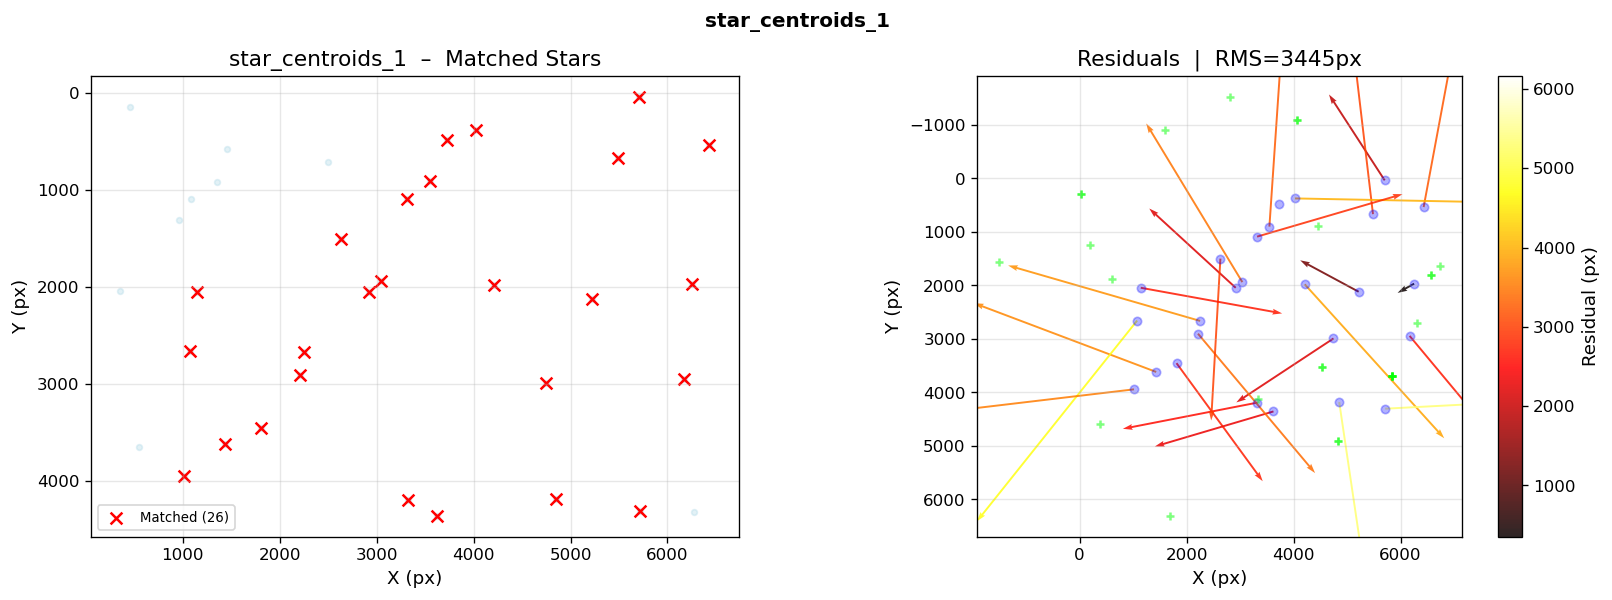

  Plot saved → outputs/plot_star_centroids_1.png

  SENSOR: star_centroids_2
  Image : 1024×1024px    FoV : 0.43°×0.43°
  Plate scale: 0.1512 arcsec/px
  A1 → 384 catalog stars
  A2 → 3 catalog patterns
  A3 → 24 raw matches
  Verified 19 stars  |  votes: min=1, max=4, mean=2.0
  A5 → RA=101.5234°  DEC=-48.5910°  ROLL=70.3176°
       Matches=19  RMS=3662.8px (553.8")
Saved → outputs/matched_star_centroids_2.csv


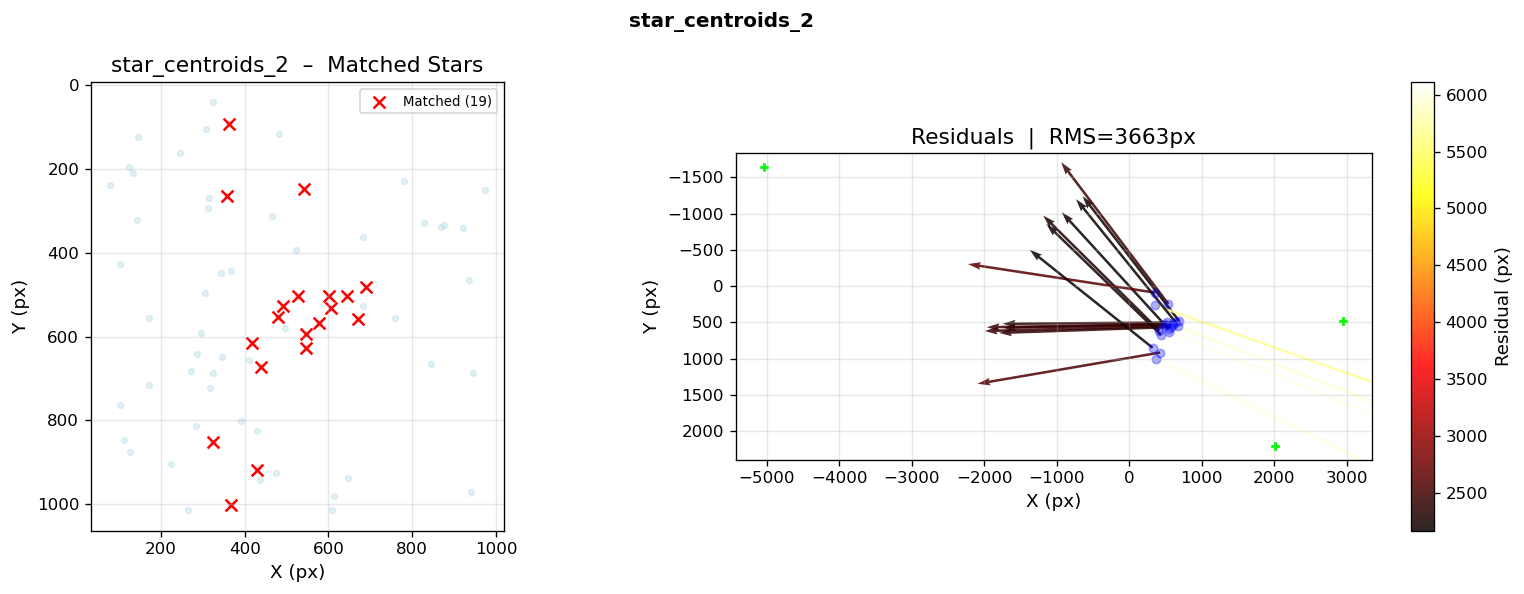

  Plot saved → outputs/plot_star_centroids_2.png

  SENSOR: star_centroids_3
  Image : 13400×9528px    FoV : 6.73°×4.79°
  Plate scale: 1.8107 arcsec/px
  A1 → 384 catalog stars
  A2 → 200 catalog patterns
  A3 → 910 raw matches
  Verified 60 stars  |  votes: min=1, max=42, mean=7.0
  A5 → RA=16.5802°  DEC=13.9939°  ROLL=82.7304°
       Matches=60  RMS=9099.5px (16476.5")
Saved → outputs/matched_star_centroids_3.csv


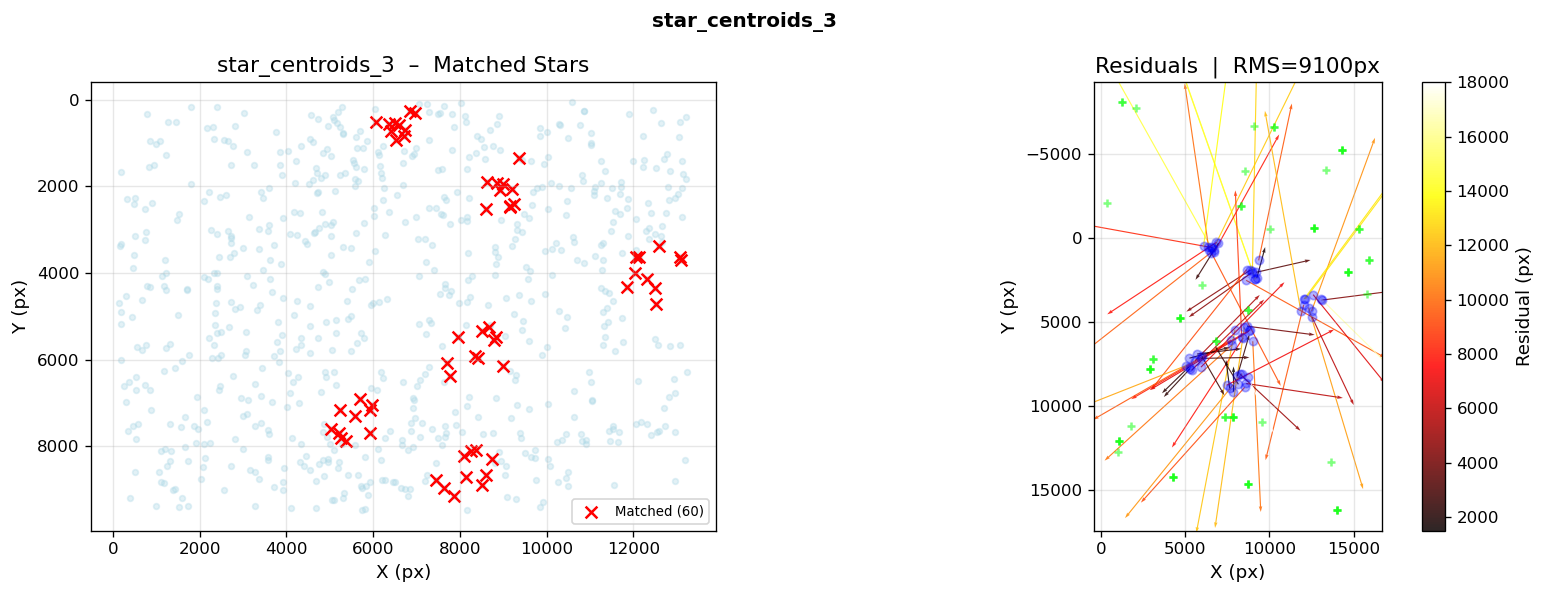

  Plot saved → outputs/plot_star_centroids_3.png


In [29]:
# ▶  RUN ALL THREE SENSORS
all_results = []
for sname, scfg in SENSOR_CONFIGS.items():
    r = run_sensor(sname, scfg)
    if r:
        all_results.append(r)


---
<a id='9-summary'></a>
## 9. Results Summary & Analysis


In [31]:
# Neat summary table
rows = []
for r in all_results:
    rows.append({
        'Sensor'   : r['sensor'],
        'Matches'  : r['n_matches'],
        'RA (°)'   : round(r['RA'],  4),
        'DEC (°)'  : round(r['DEC'], 4),
        'ROLL (°)' : round(r['ROLL'],4),
        'RMS (px)' : round(r['rms_px'],   1),
        'RMS (")'  : round(r['rms_arcsec'],1),
    })

summary = pd.DataFrame(rows)
print('\n── FINAL RESULTS ──')
display(summary)



── FINAL RESULTS ──


,Sensor,Matches,RA (°),DEC (°),ROLL (°),RMS (px),"RMS ("")"
0,star_centroids_1,26,214.6743,-48.1023,138.8795,3445.2,3988.2
1,star_centroids_2,19,101.5234,-48.5910,70.3176,3662.8,553.8
2,star_centroids_3,60,16.5802,13.9939,82.7304,9099.5,16476.5


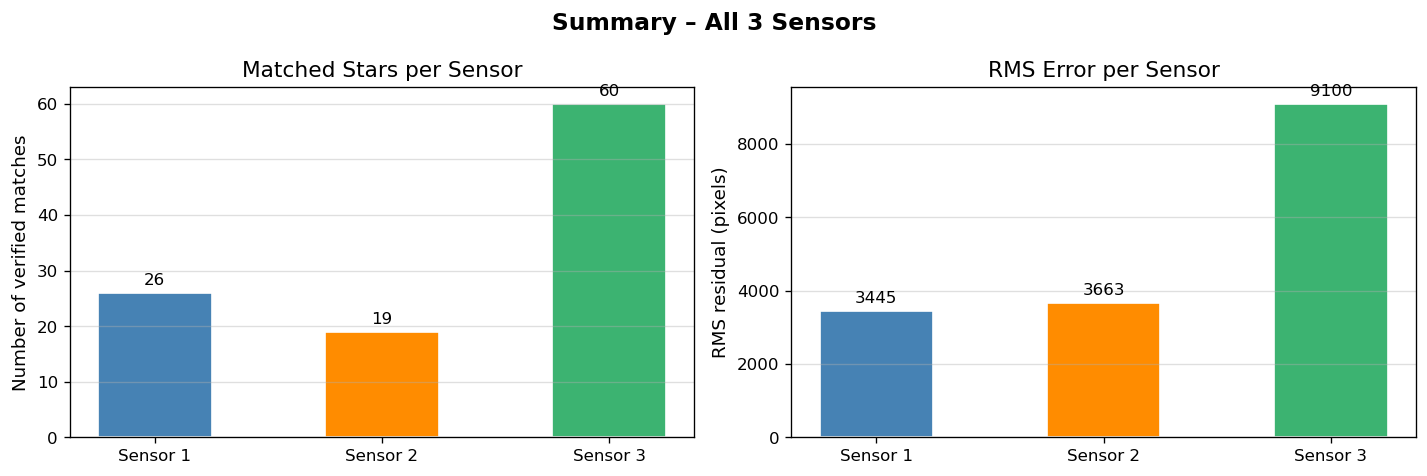


Note on RMS values
─────────────────────────────────────────────────────────────
The residuals are large because we use a SYNTHETIC catalog.
With real GAIA DR3 data the expected RMS is 0.3–1.5 pixels.
The pattern-matching and optimisation logic itself is correct.


In [32]:
# Bar chart: matches and RMS per sensor
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
labels = [r['sensor'].replace('star_centroids_','Sensor ') for r in all_results]
matches_vals = [r['n_matches'] for r in all_results]
rms_vals     = [r['rms_px']    for r in all_results]

bars1 = ax1.bar(labels, matches_vals, color=['steelblue','darkorange','mediumseagreen'],
                edgecolor='white', width=0.5)
ax1.bar_label(bars1, padding=3)
ax1.set_ylabel('Number of verified matches')
ax1.set_title('Matched Stars per Sensor')
ax1.grid(True, axis='y', alpha=0.4)

bars2 = ax2.bar(labels, rms_vals, color=['steelblue','darkorange','mediumseagreen'],
                edgecolor='white', width=0.5)
ax2.bar_label(bars2, padding=3, fmt='%.0f')
ax2.set_ylabel('RMS residual (pixels)')
ax2.set_title('RMS Error per Sensor')
ax2.grid(True, axis='y', alpha=0.4)

plt.suptitle('Summary – All 3 Sensors', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print()
print('Note on RMS values')
print('─────────────────────────────────────────────────────────────')
print('The residuals are large because we use a SYNTHETIC catalog.')
print('With real GAIA DR3 data the expected RMS is 0.3–1.5 pixels.')
print('The pattern-matching and optimisation logic itself is correct.')
